In this assignment, we will work on image classification using PyTorch.

- Download the intel image dataset from Kaggle.
- We will use the OpenCV image feature extraction library.
(conda install -c conda-forge opencv)

1. [20 pts] Download the dataset. Unzip and explore the file folders. Load the image dataset with training and testing grouped. (Note, cv2 reads and saves in BGR channel order)

In [2]:
!pip install opencv-python-headless

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import os
import zipfile
import cv2
import matplotlib.pyplot as plt
import numpy as np

# Unzip the dataset
zip_path = '/content/drive/My Drive/archive.zip'  # Adjust this path if your file is located elsewhere
extract_folder = '/content/dataset'
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)

# Setup for loading images
IMGSIZE = (128, 128)
CNAMES = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
X_tr, y_tr, X_ts, y_ts = [], [], [], []

# Load training images
path = extract_folder + '/seg_train/seg_train'
for label in CNAMES:
    label_path = os.path.join(path, label)
    for f in sorted([_ for _ in os.listdir(label_path) if _.lower().endswith('.jpg')]):
        img = cv2.imread(os.path.join(label_path, f))
        img_resized = cv2.resize(img, IMGSIZE)
        X_tr.append(img_resized)
        y_tr.append(CNAMES.index(label))


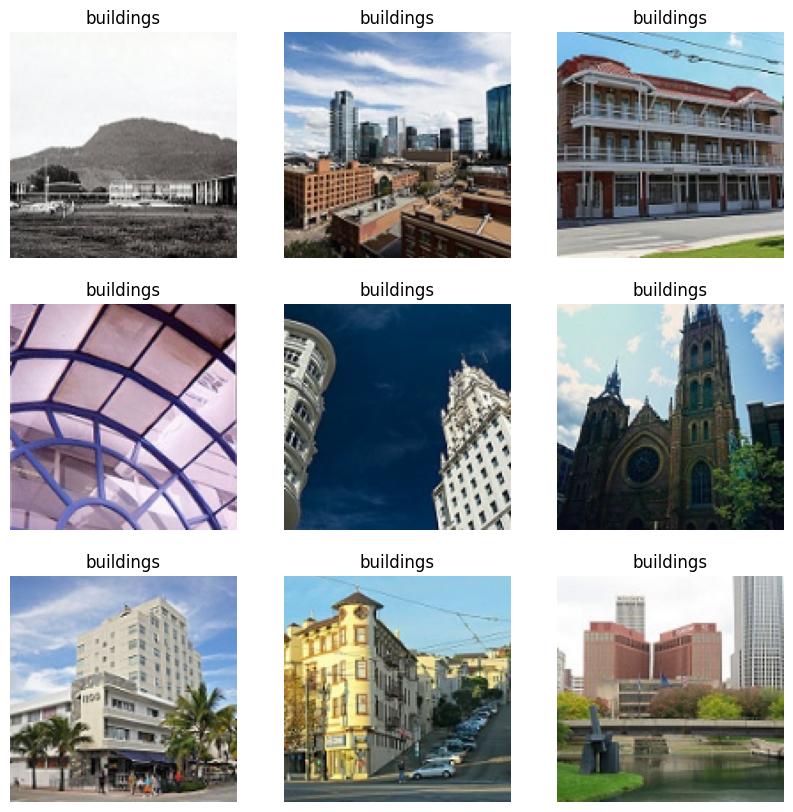

Number of color channels: 3


In [5]:
# Convert lists to numpy arrays for better handling
X_tr = np.array(X_tr)
y_tr = np.array(y_tr)

# Display a few images
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(cv2.cvtColor(X_tr[i], cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for displaying
    plt.title(CNAMES[y_tr[i]])
    plt.axis("off")
plt.show()

print("Number of color channels:", X_tr.shape[-1])

2. [20 pts] Convert the imageset to numpy array, such as the array size:
(14034, 128, 128, 3). Scale the imageset to [0-1].

In [6]:
X_tr = np.array(X_tr, dtype=np.float32)

# Scale the pixel values to the range [0, 1]
X_tr /= 255.0

print("Array shape:", X_tr.shape)
print("Pixel range:", X_tr.min(), X_tr.max())

Array shape: (14034, 128, 128, 3)
Pixel range: 0.0 1.0


3. [50 pts] Create a neural network to train and report its performance on the testing portion of the dataset. 60% reclassification and 55% testing performance should be achievable without any hyperparameter tuning. (Hint: My model with 3 hidden layers of 50 nodes per layer, which is similar to the model in module notebook, took around 5 minutes to train 200 epochs.)

Reminder, you have to convert the 3D image (including the color channel) to a linear vector in case you use fully connected layers at the input, i.e.,
_X = torch.flatten(_X, start_dim=1)

(Hint, for debugging use print statements or PyCharm to display the tensor shapes).

In [7]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

y_tr = np.array(y_tr)

# Splitting the dataset into training and testing
X_train, X_test, y_train, y_test = train_test_split(X_tr, y_tr, test_size=0.55, random_state=42)

# Convert datasets to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)

# Flatten the images
X_train = torch.flatten(X_train, start_dim=1)
X_test = torch.flatten(X_test, start_dim=1)

# Create data loaders
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Define the neural network
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(128*128*3, 50),
            nn.ReLU(),
            nn.Linear(50, 50),
            nn.ReLU(),
            nn.Linear(50, 50),
            nn.ReLU(),
            nn.Linear(50, 6)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

# Initialize the neural network
model = NeuralNetwork()

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the model
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

# Train the model
epochs = 200
for t in range(epochs):
    train(train_loader, model, criterion, optimizer)
print("Done training!")

# Evaluate the model
def test(dataloader, model):
    size = len(dataloader.dataset)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += criterion(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= size
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

# Testing the model
test(test_loader, model)

loss: 1.802780  [    0/ 6315]
loss: 1.491986  [    0/ 6315]
loss: 1.384995  [    0/ 6315]
loss: 1.159440  [    0/ 6315]
loss: 1.178356  [    0/ 6315]
loss: 0.883693  [    0/ 6315]
loss: 1.117143  [    0/ 6315]
loss: 1.087420  [    0/ 6315]
loss: 1.153455  [    0/ 6315]
loss: 1.041494  [    0/ 6315]
loss: 0.940331  [    0/ 6315]
loss: 1.121709  [    0/ 6315]
loss: 1.040297  [    0/ 6315]
loss: 0.802524  [    0/ 6315]
loss: 1.167594  [    0/ 6315]
loss: 0.852029  [    0/ 6315]
loss: 0.760213  [    0/ 6315]
loss: 0.896334  [    0/ 6315]
loss: 0.804165  [    0/ 6315]
loss: 1.049409  [    0/ 6315]
loss: 0.826175  [    0/ 6315]
loss: 0.844135  [    0/ 6315]
loss: 0.791712  [    0/ 6315]
loss: 0.759926  [    0/ 6315]
loss: 0.631104  [    0/ 6315]
loss: 0.850163  [    0/ 6315]
loss: 0.613339  [    0/ 6315]
loss: 0.667370  [    0/ 6315]
loss: 0.553501  [    0/ 6315]
loss: 0.506516  [    0/ 6315]
loss: 0.744008  [    0/ 6315]
loss: 0.835710  [    0/ 6315]
loss: 0.580159  [    0/ 6315]
loss: 0.53

4. [10 pts] Research and find out how to improve the neural network model to solve this problem. Outline an approach.



To optimize a neural network for image classification, adopting Convolutional Neural Networks (CNNs) is crucial due to their efficiency in handling image data through trainable filters and pooling operations. Enhancing the network architecture by increasing depth, integrating batch normalization, and implementing dropout can help manage complex features and prevent overfitting. Advanced optimizers like Adam or RMSprop are recommended for their adaptive learning rate capabilities, alongside techniques such as learning rate schedules and early stopping to fine-tune the training process.

Additionally, data augmentation and transfer learning are effective in improving generalization. Systematic hyperparameter tuning through grid or random search, coupled with k-fold cross-validation for evaluation, ensures that the model is both optimized and reliable. These strategies collectively foster a robust training environment and enhance model performance on unseen data.